## load pkgs

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import os

In [2]:
sc.set_figure_params(dpi=120, dpi_save=300, vector_friendly=False, figsize=(4,4))
sc.settings.verbosity = 1
sc.logging.print_header()

%matplotlib inline 

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.23.5 scipy==1.9.1 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.10.4 pynndescent==0.5.11


## plot setting

In [ ]:
%run ./py_script/marker.py

In [ ]:
%run ./py_script/colorconfig.py

## workpath

In [4]:
workdir = '/home/zhepan/Project/scRNA_BC_metastases/Data/SingleCell/inHouse/'
location = 'LiverM'
sample_list = ['BrM1','BrM2','BrM3']
resdir = '/home/zhepan/Project/scRNA_BC_metastases/Data/SingleCell/inHouse/'

In [3]:
filtertype = 'decontx'

In [7]:
adata = sc.read_h5ad(resdir+'/'+location+'/'+location+'_'+filtertype+'_anno.h5ad')

## process

In [149]:
adatas = [sc.read_h5ad(workdir+location+'/'+sample+'/'+filtertype+'_doublet.h5ad') for sample in sample_list]

In [151]:
for index, adata in enumerate(adatas):
    adatas[index].obs_names = [sample_list[index]+'-'+ obs_name[0:16] for obs_name in adatas[index].obs_names]

In [152]:
adata = ad.concat([adatas[index] for index,adata in enumerate(adatas)], uns_merge='same', join='outer')
adata

AnnData object with n_obs × n_vars = 12176 × 17750
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'scDblFinder.class', 'SampleID', 'percent_mt', 'percent_hb', 'percent_rb', 'S.Score', 'G2M.Score', 'Phase'

In [157]:
adata.obs['SampleID'].value_counts()

SampleID
BrM3    5455
BrM1    3826
BrM2    2895
Name: count, dtype: int64

In [159]:
adata.write_h5ad(resdir+'/'+location+'/'+location+'_'+filtertype+'_raw.h5ad')

In [ ]:
adata = sc.read_h5ad(resdir+'/'+location+'/'+location+'_'+filtertype+'_raw.h5ad')

In [ ]:
mt_gene = adata.var_names[adata.var_names.str.startswith('MT-')]
hb_gene = adata.var_names[adata.var_names.str.contains('^HB[^P]')]
rp_gene = adata.var_names[adata.var_names.str.startswith(('RPS','RPL'))]

In [ ]:
remove_gene = np.concatenate([mt_gene], axis = None)
remove_gene

In [ ]:
# sn optional
adata = adata[:,adata.var_names.isin(remove_gene) == False]

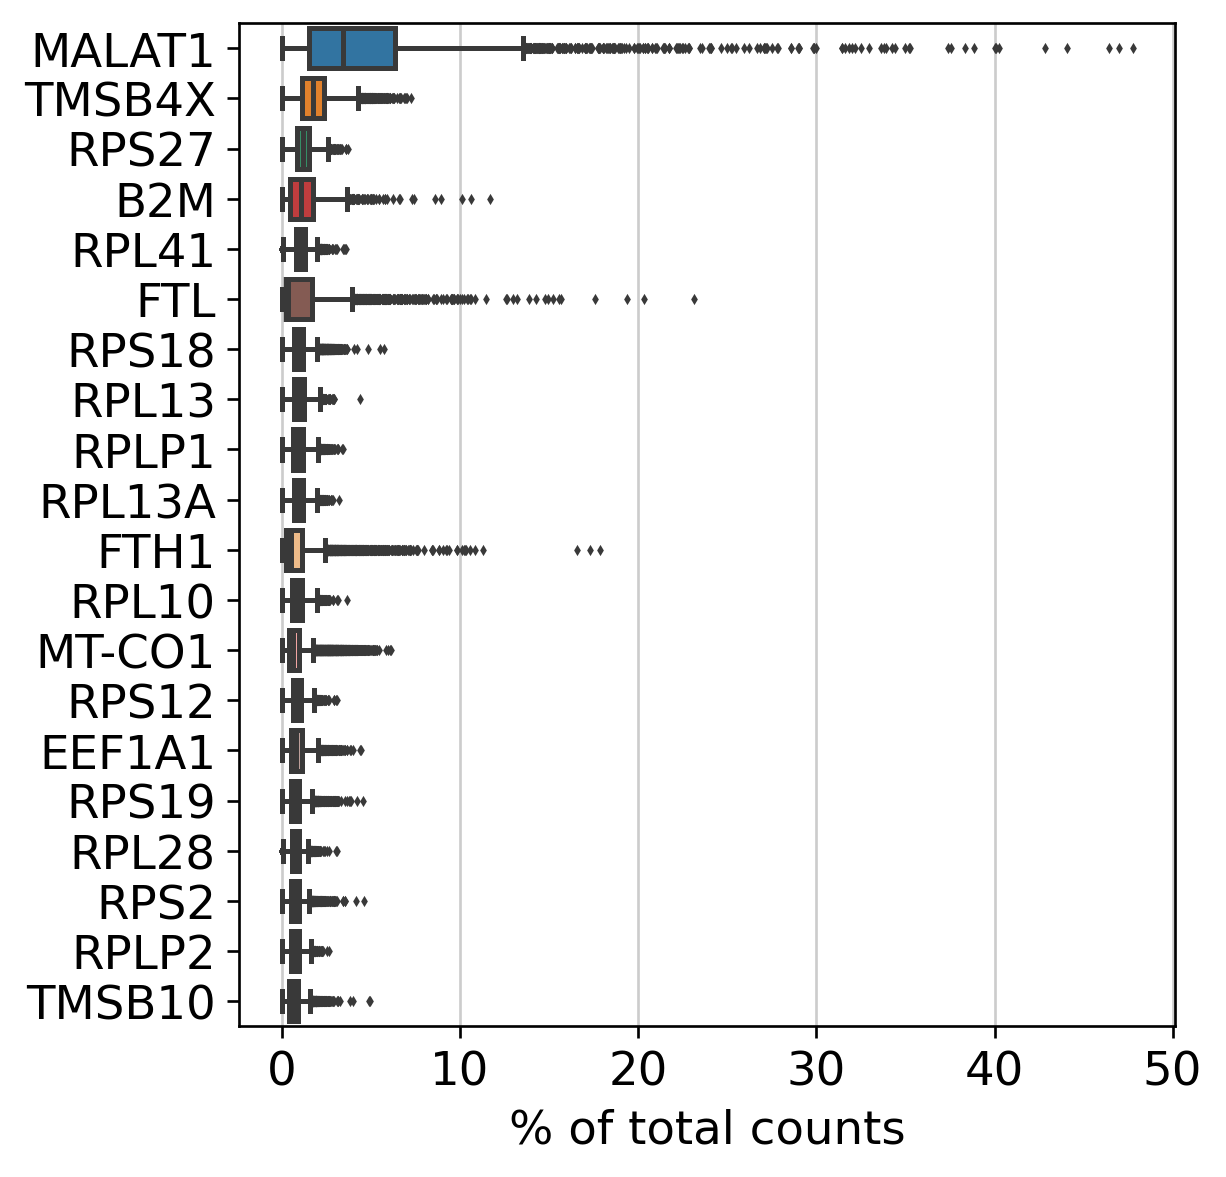

In [160]:
%%capture --no-display
sc.pl.highest_expr_genes(adata, n_top=20)

In [99]:
adata

AnnData object with n_obs × n_vars = 8160 × 21910
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'scDblFinder.class', 'SampleID', 'percent_mt', 'percent_hb', 'percent_rb', 'S.Score', 'G2M.Score', 'Phase'
    var: 'name'

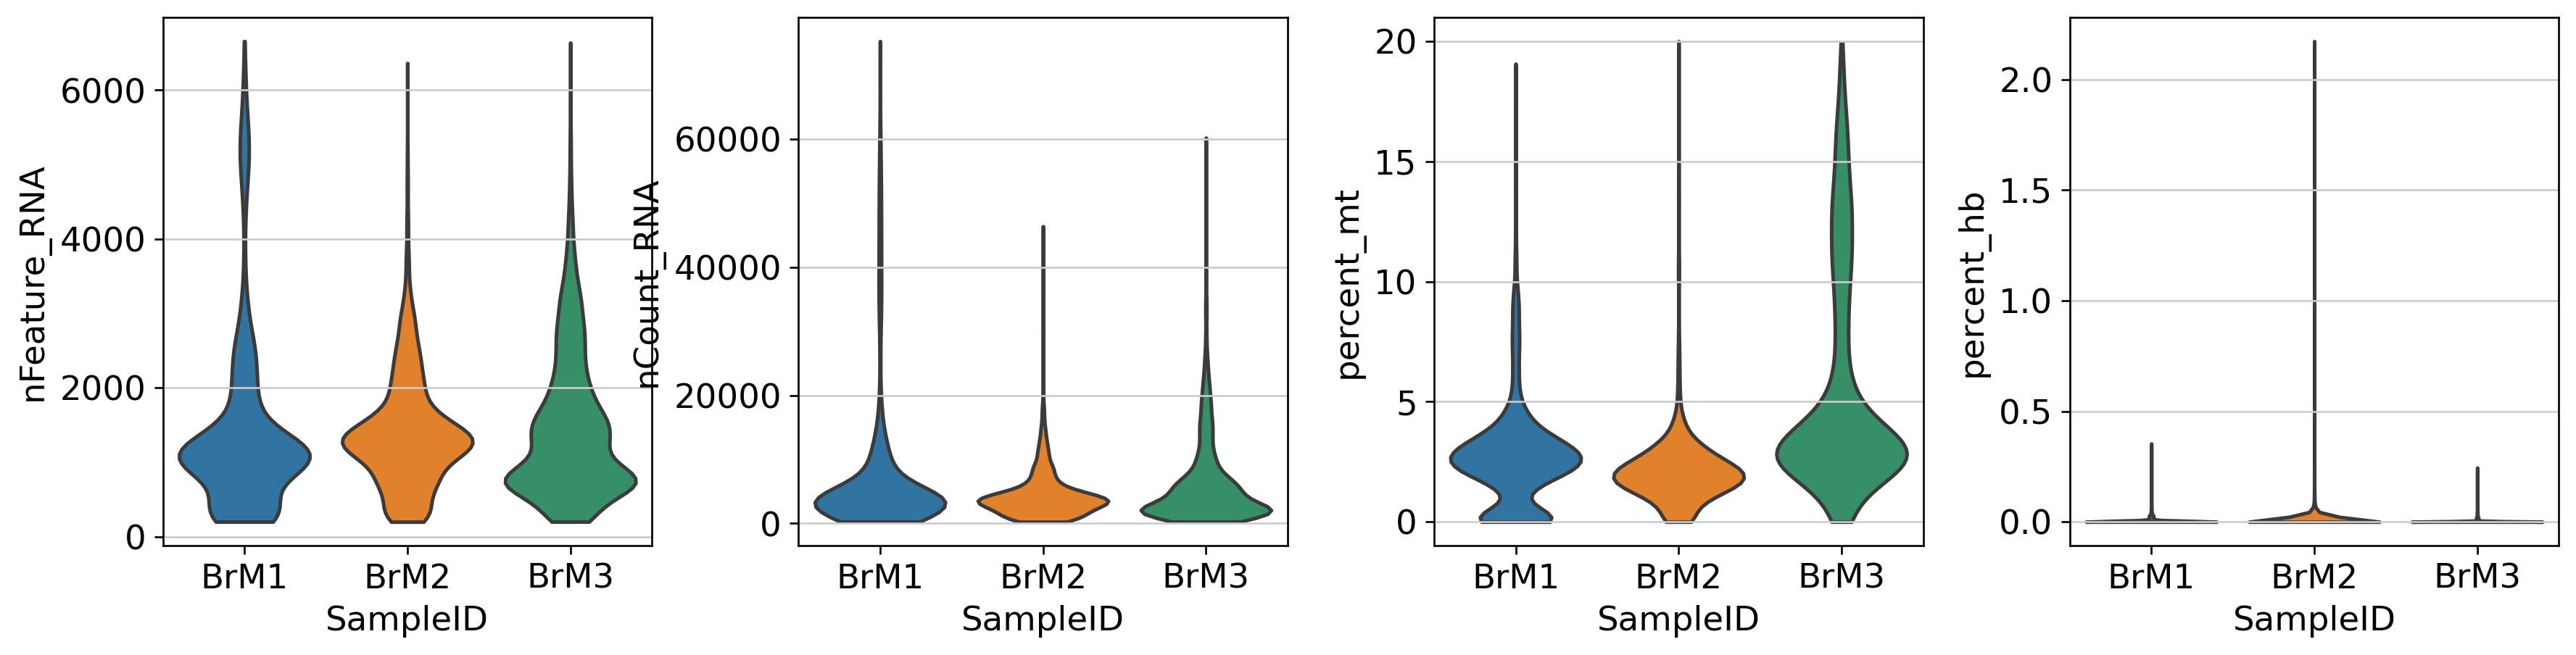

In [161]:
%%capture --no-display
sc.pl.violin(adata, [
    'nFeature_RNA',
    'nCount_RNA', 
    'percent_mt',
    'percent_hb',
    ],groupby='SampleID',
    jitter=0.4, multi_panel=True,stripplot=False)

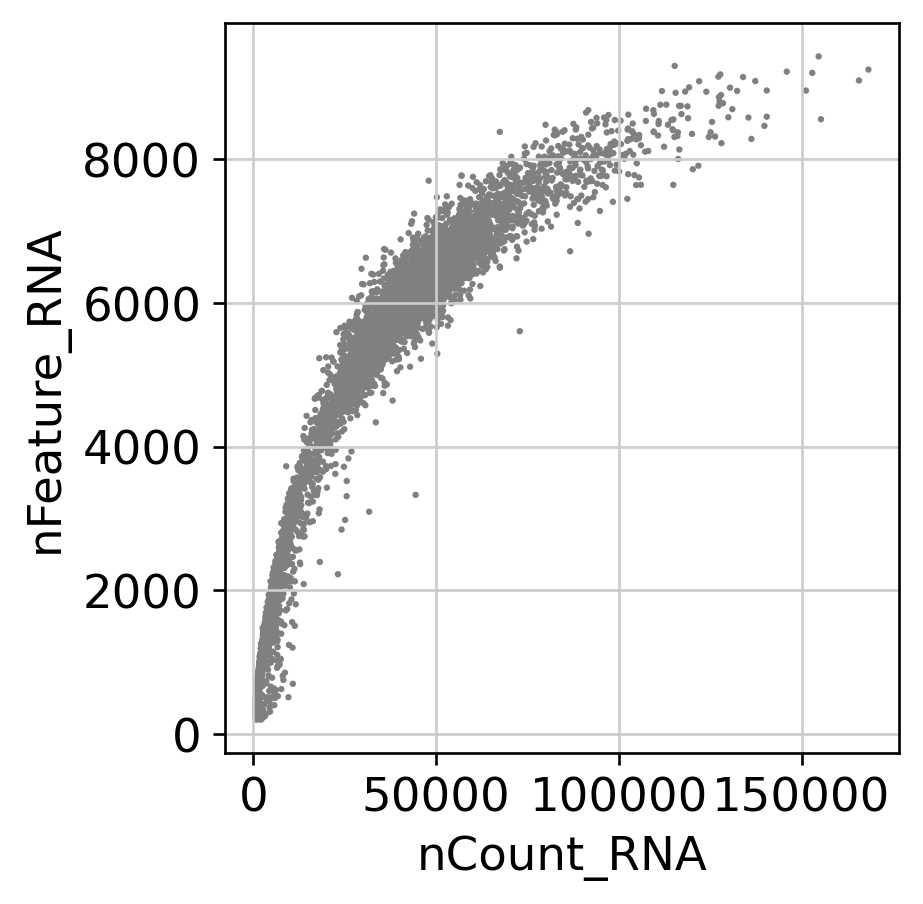

In [101]:
sc.pl.scatter(adata, x='nCount_RNA', y='nFeature_RNA')

In [ ]:
adata.obs.groupby('SampleID')['nCount_RNA'].describe()

In [ ]:
# different location require seperated threshold

In [102]:
adata = adata[adata.obs.nFeature_RNA < 9000, :] # BoM 8000, BrM 8000, LiverM 10000, public_BrM_GSE143423 9000
adata = adata[adata.obs.nCount_RNA < 100000, :] # BoM 60000, BrM 50000, LiverM 80000, public_BrM_GSE143423 100000
adata = adata[adata.obs.nCount_RNA > 500,:] # BoM 500, BrM 500, LiverM 300, public_BrM_GSE143423 500
adata = adata[adata.obs.percent_mt < 40, :] # BoM 20, BrM none, LiverM 40, public_BrM_GSE143423 40
#adata = adata[adata.obs.percent_hb < 0.2, :]
adata = adata[adata.obs['scDblFinder.class'] == 'singlet', :]

In [103]:
adata.obs.SampleID.value_counts()

SampleID
BrM1    7128
Name: count, dtype: int64

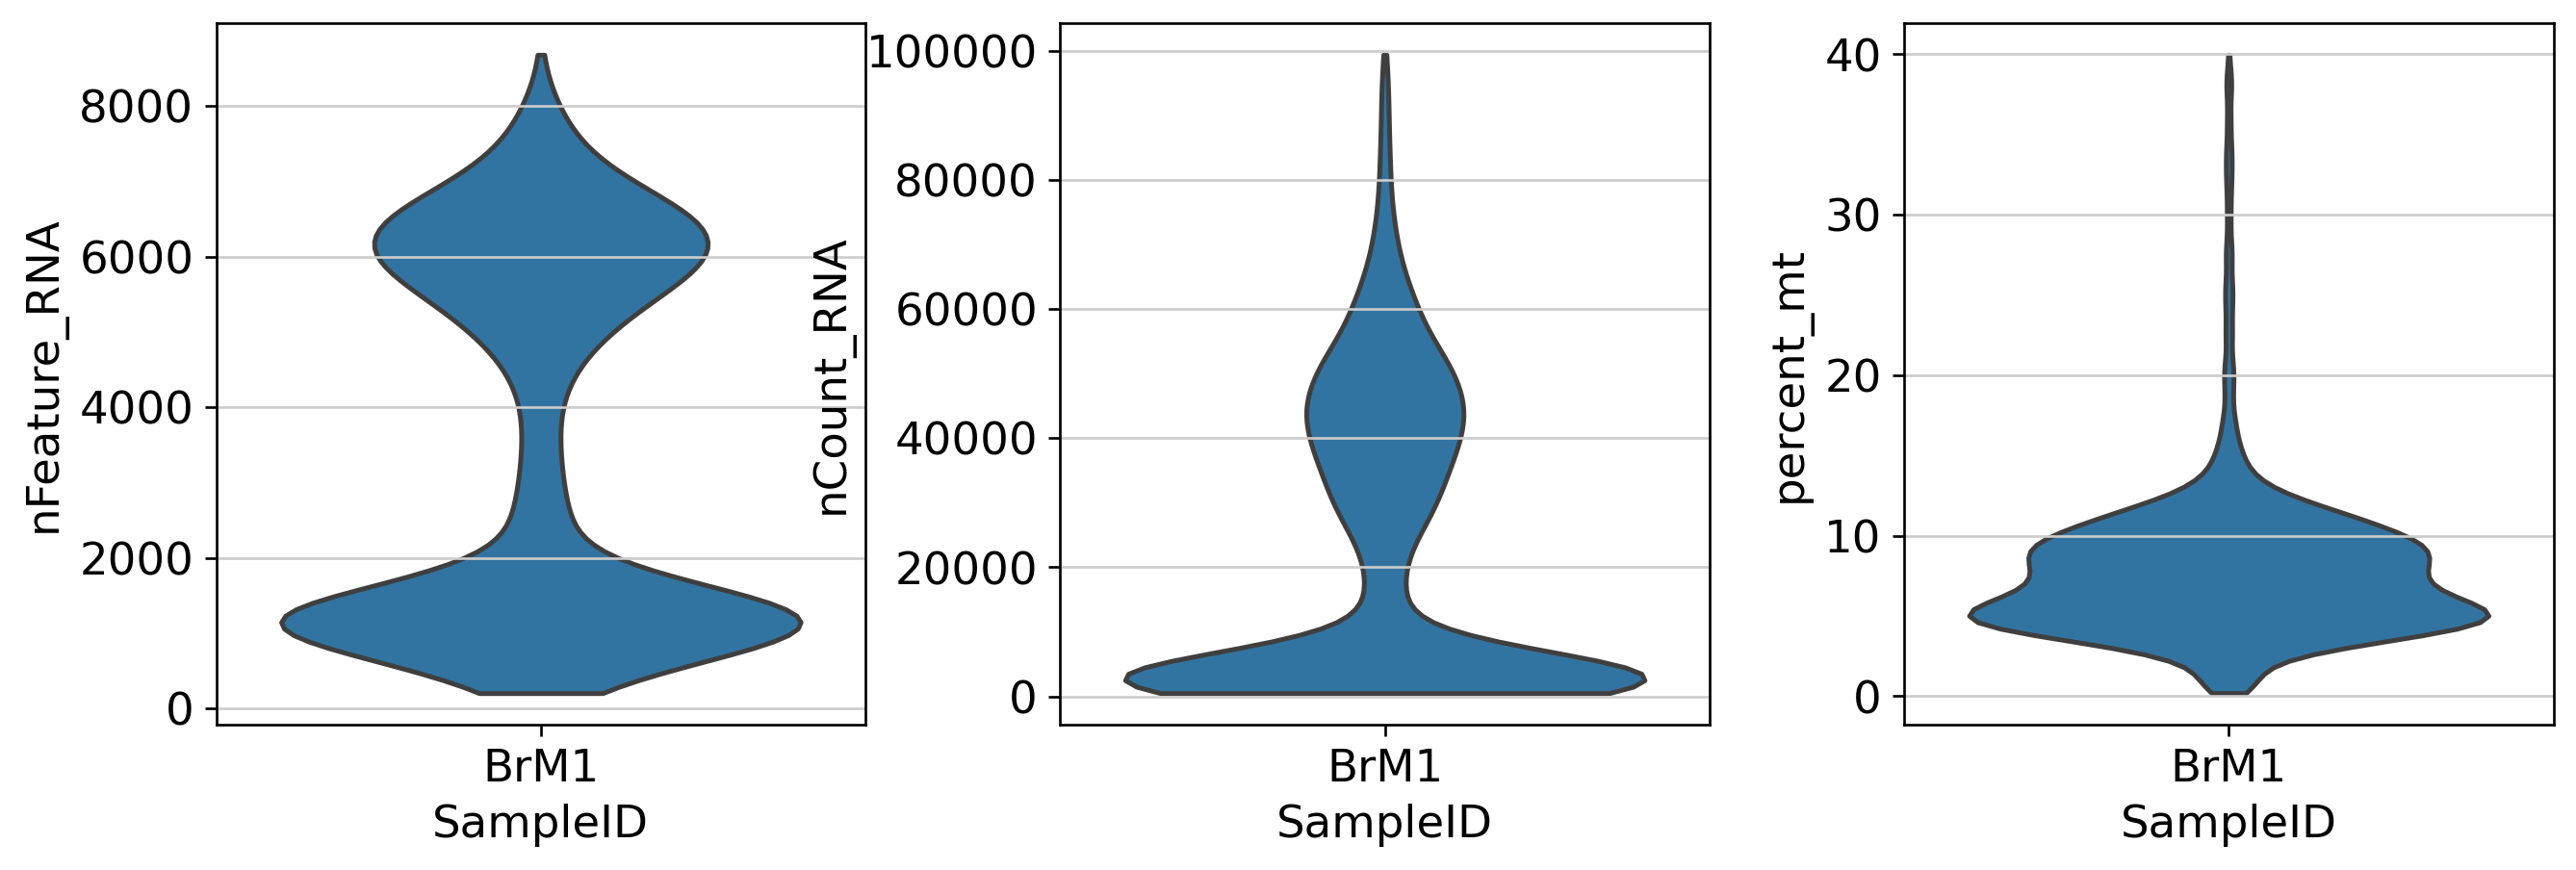

In [104]:
%%capture --no-display
sc.pl.violin(adata, ['nFeature_RNA', 'nCount_RNA','percent_mt'],groupby='SampleID',
             jitter=0.4, multi_panel=True,stripplot=False)

In [ ]:
%%capture --no-display
# ambient RNA check each data with KRT-genelist
for sample in sample_list:
    adata_sample = adata[adata.obs['SampleID'] == sample, :]
    adata_sample.layers['count'] = adata_sample.X.copy()
    sc.pp.normalize_total(adata_sample, target_sum=1e4)
    sc.pp.log1p(adata_sample)
    adata_sample.raw = adata_sample
    sc.pp.highly_variable_genes(
    adata_sample,layer = 'count',
    flavor="seurat_v3",
    n_top_genes=2000,
    subset=True)
    sc.pp.scale(adata_sample, max_value=10)
    sc.tl.pca(adata_sample, svd_solver='arpack')
    sc.pp.neighbors(adata_sample, n_neighbors=15, n_pcs=40)
    sc.tl.umap(adata_sample,min_dist=0.2)
    sc.pl.umap(adata_sample,color = ['EPCAM','COL1A1','PTPRC'], 
            ncols = 5, show = False, frameon= False)

In [ ]:
adata.write_h5ad(resdir+'/'+location+'/'+location+'_'+filtertype+'_qc.h5ad')

In [ ]:
adata = sc.read_h5ad(resdir+'/'+location+'/'+location+'_'+filtertype+'_qc.h5ad')

In [162]:
adata.layers['count'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [163]:
sc.pp.highly_variable_genes(
    adata,layer = 'count',
    flavor="seurat_v3",
    n_top_genes=2000,
    batch_key='SampleID',
    subset=True
)

In [164]:
sc.pp.regress_out(adata, ['S.Score', 'G2M.Score'])
sc.pp.scale(adata, max_value=10)

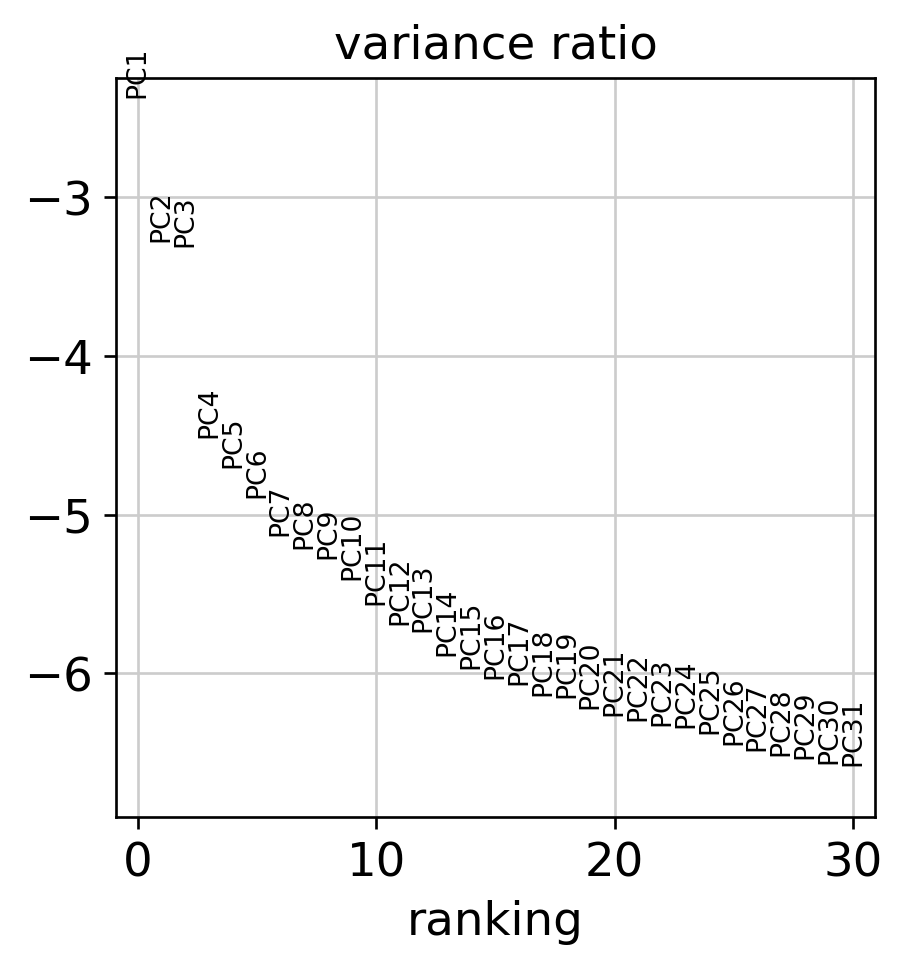

In [165]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [109]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata,min_dist=0.5)

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.ma

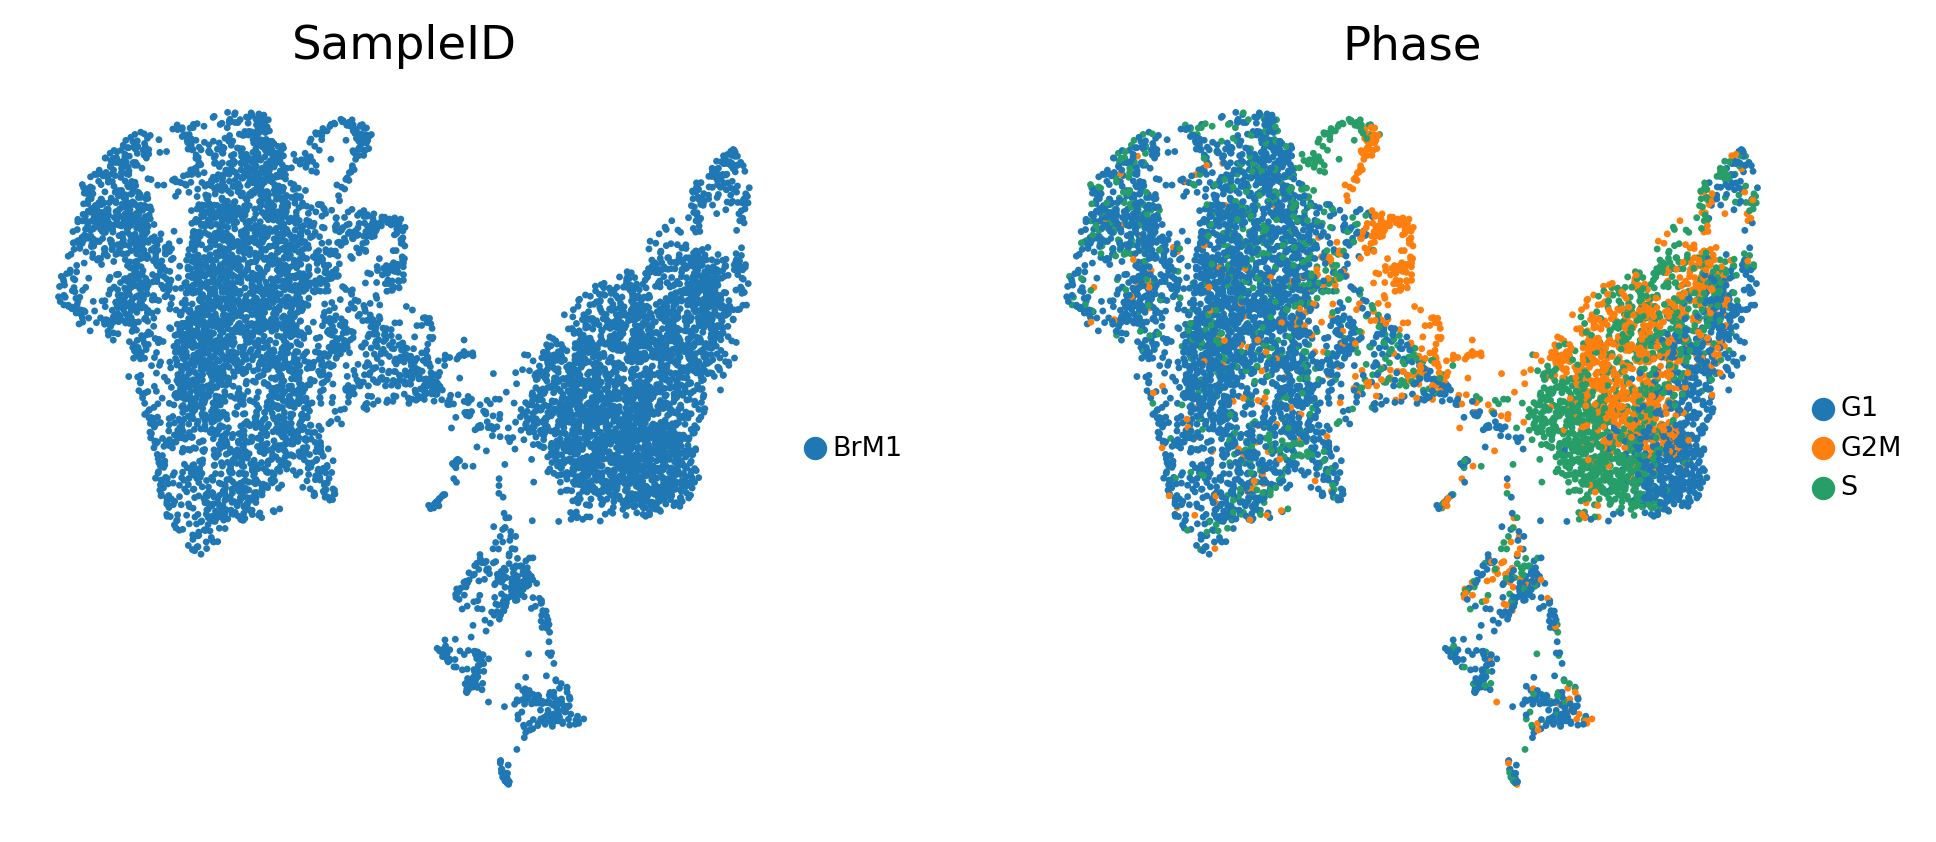

In [110]:
sc.pl.umap(adata,color = ['SampleID','Phase'], ncols = 2,frameon=False,legend_fontsize='xx-small')

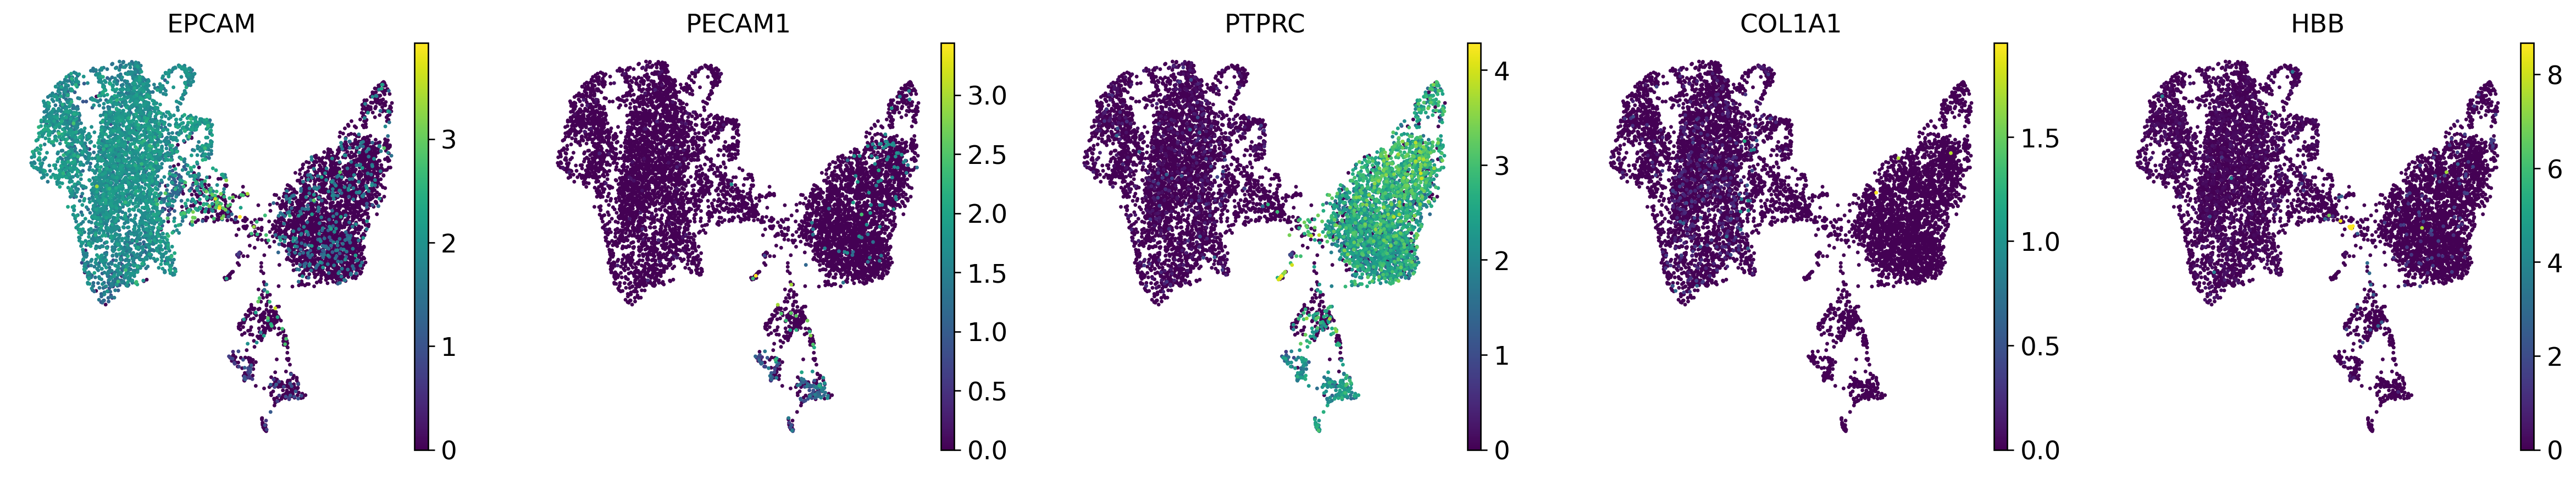

In [111]:
sc.pl.umap(adata,color = ['EPCAM','PECAM1','PTPRC','COL1A1','HBB'], frameon= False, ncols = 5)

In [112]:
for i in [0.2,0.5,1.0]:
    sc.tl.leiden(adata, resolution = i, key_added = ('leiden_'+str(i)))

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.ma

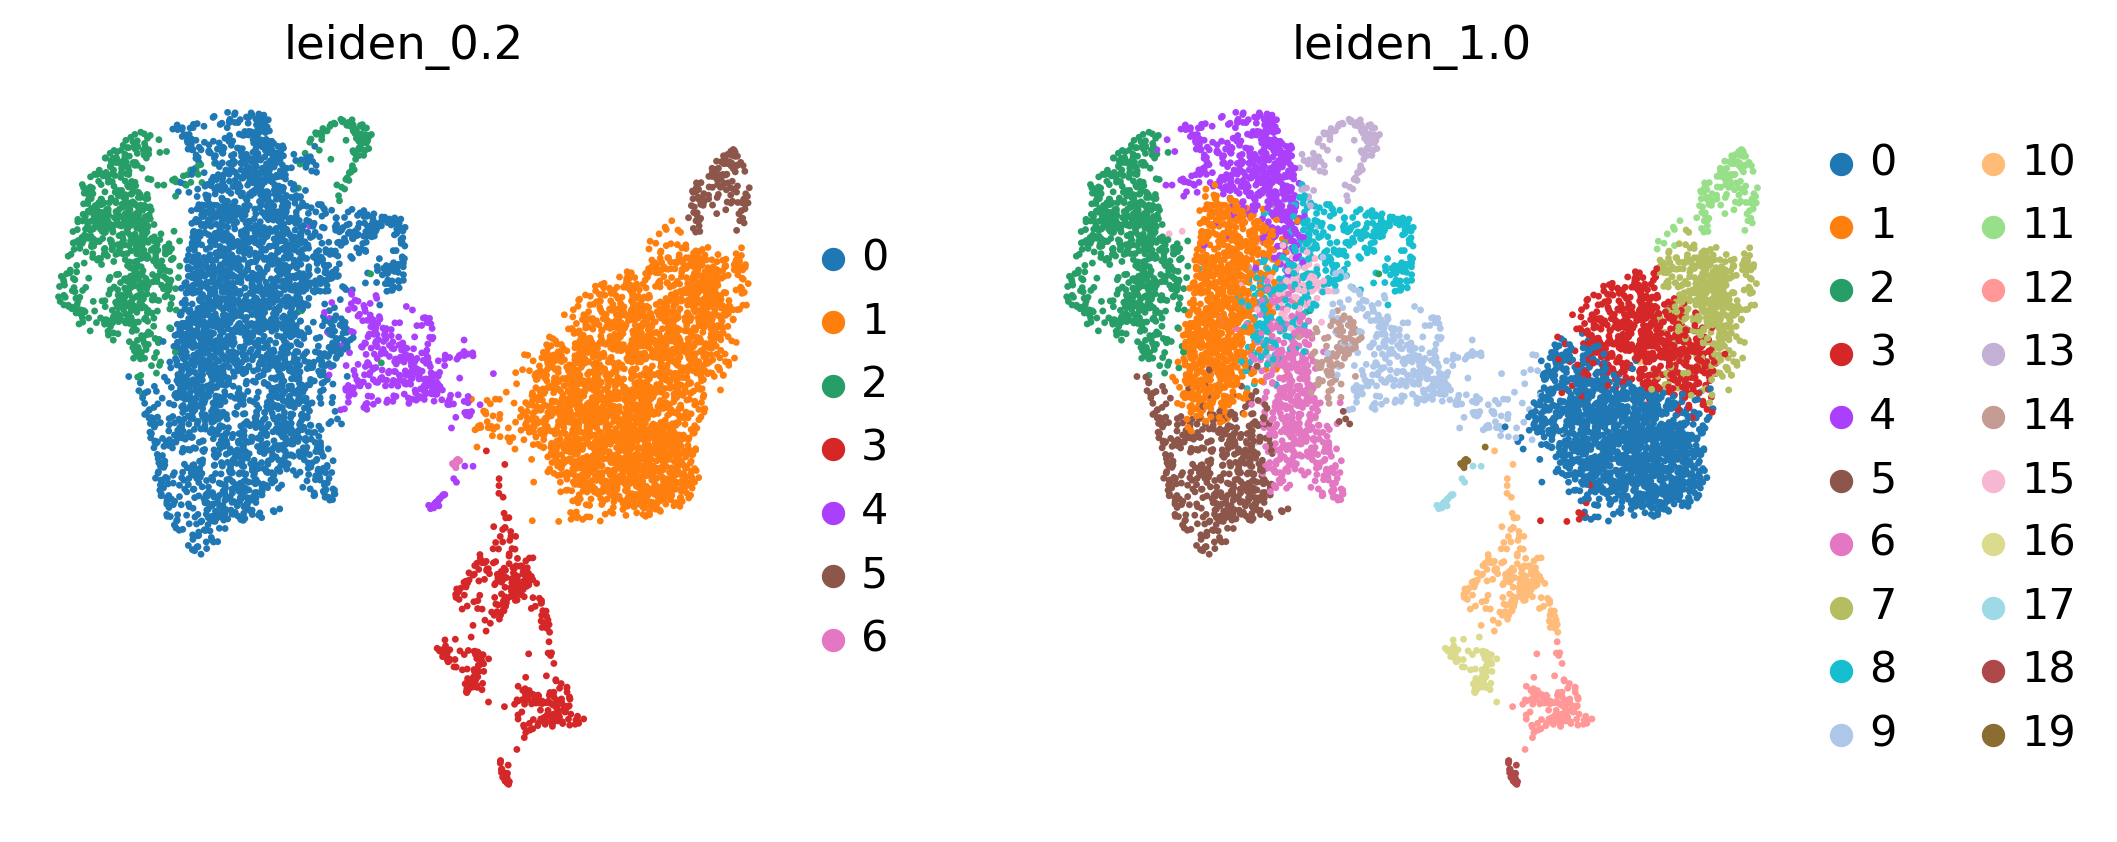

In [121]:
sc.pl.umap(adata, color=[ "leiden_0.2","leiden_1.0"], frameon=False, ncols=4)

In [114]:
adata_deg = sc.read_h5ad(resdir+'/'+location+'/'+filtertype+'_doublet.h5ad')

In [115]:
adata_deg = adata_deg[adata_deg.obs.index.isin(adata.obs.index),:]

In [116]:
sc.pp.normalize_total(adata_deg, target_sum = 1e4)
sc.pp.log1p(adata_deg)

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [122]:
cluster_select = 'leiden_0.2'

In [123]:
adata_deg.obs[cluster_select] = adata.obs[cluster_select]

In [124]:
%%capture --no-display
sc.tl.rank_genes_groups(adata_deg, cluster_select, method='wilcoxon')

In [125]:
marker_enrich = pd.DataFrame(adata_deg.uns['rank_genes_groups']['names'])

In [55]:
import gseapy as gp

In [140]:
interest_cluster = '6'
marker_enrich[interest_cluster].head(10)

0    TNFRSF17
1       IGHA2
2       IGHA1
3        MZB1
4      JCHAIN
5       DERL3
6     POU2AF1
7      TXNDC5
8       CCR10
9     HSP90B1
Name: 6, dtype: object

In [141]:
enr = gp.enrichr(marker_enrich[interest_cluster].head(30), gene_sets=['Azimuth_2023'], organism='human', outdir=None)
enr.results.head(5)

Gene_set                                          Term Overlap  \
0  Azimuth_2023                           PBMC-L3-Plasma Cell     8/9   
1  Azimuth_2023       Lung V2 (HLCA)-ann Level 4-Plasma Cells     7/9   
2  Azimuth_2023  Lung V2 (HLCA)-ann Finest level-Plasma Cells     7/9   
3  Azimuth_2023                               Liver-L2-Plasma     6/9   
4  Azimuth_2023                             Lung v1-L2-Plasma     6/9   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  8.289794e-23      5.554162e-21            0                     0   
1  2.880461e-19      6.433029e-18            0                     0   
2  2.880461e-19      6.433029e-18            0                     0   
3  5.594777e-16      5.355000e-15            0                     0   
4  5.594777e-16      5.355000e-15            0                     0   

    Odds Ratio  Combined Score  \
0  7261.454545   369204.532304   
1  3038.608696   129721.749569   
2  3038.608696   129721.749569   
3  1663.916667    58435.968085   
4  1663.916667    58435.968085   

                                               Genes  
0  CD79A;DERL3;POU2AF1;TNFRSF17;IGHA1;JCHAIN;ITM2...  
1      FKBP11;ISG20;CD79A;MZB1;TNFRSF17;IGHA1;JCHAIN  
2      FKBP11;ISG20;CD79A;MZB1;TNFRSF17;IGHA1;JCHAIN  
3                FKBP11;SSR4;DERL3;MZB1;SEC11C;ITM2C  
4         SSR4;DERL3;POU2AF1;TNFRSF17;SEC11C;HSP90B1

In [142]:
cl_major={
    "0": "Epi",
    "1": "Imm",
    "2": "Epi",
    "3": "Imm",
    "4": "Epi",
    "5": "Imm",
    "6": "Imm",
}

In [143]:
adata.obs["cl_major"] = adata.obs[cluster_select].map(cl_major)

In [144]:
adata.obs["cl_major"].value_counts()

cl_major
Epi    4097
Imm    3031
Name: count, dtype: int64

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.ma

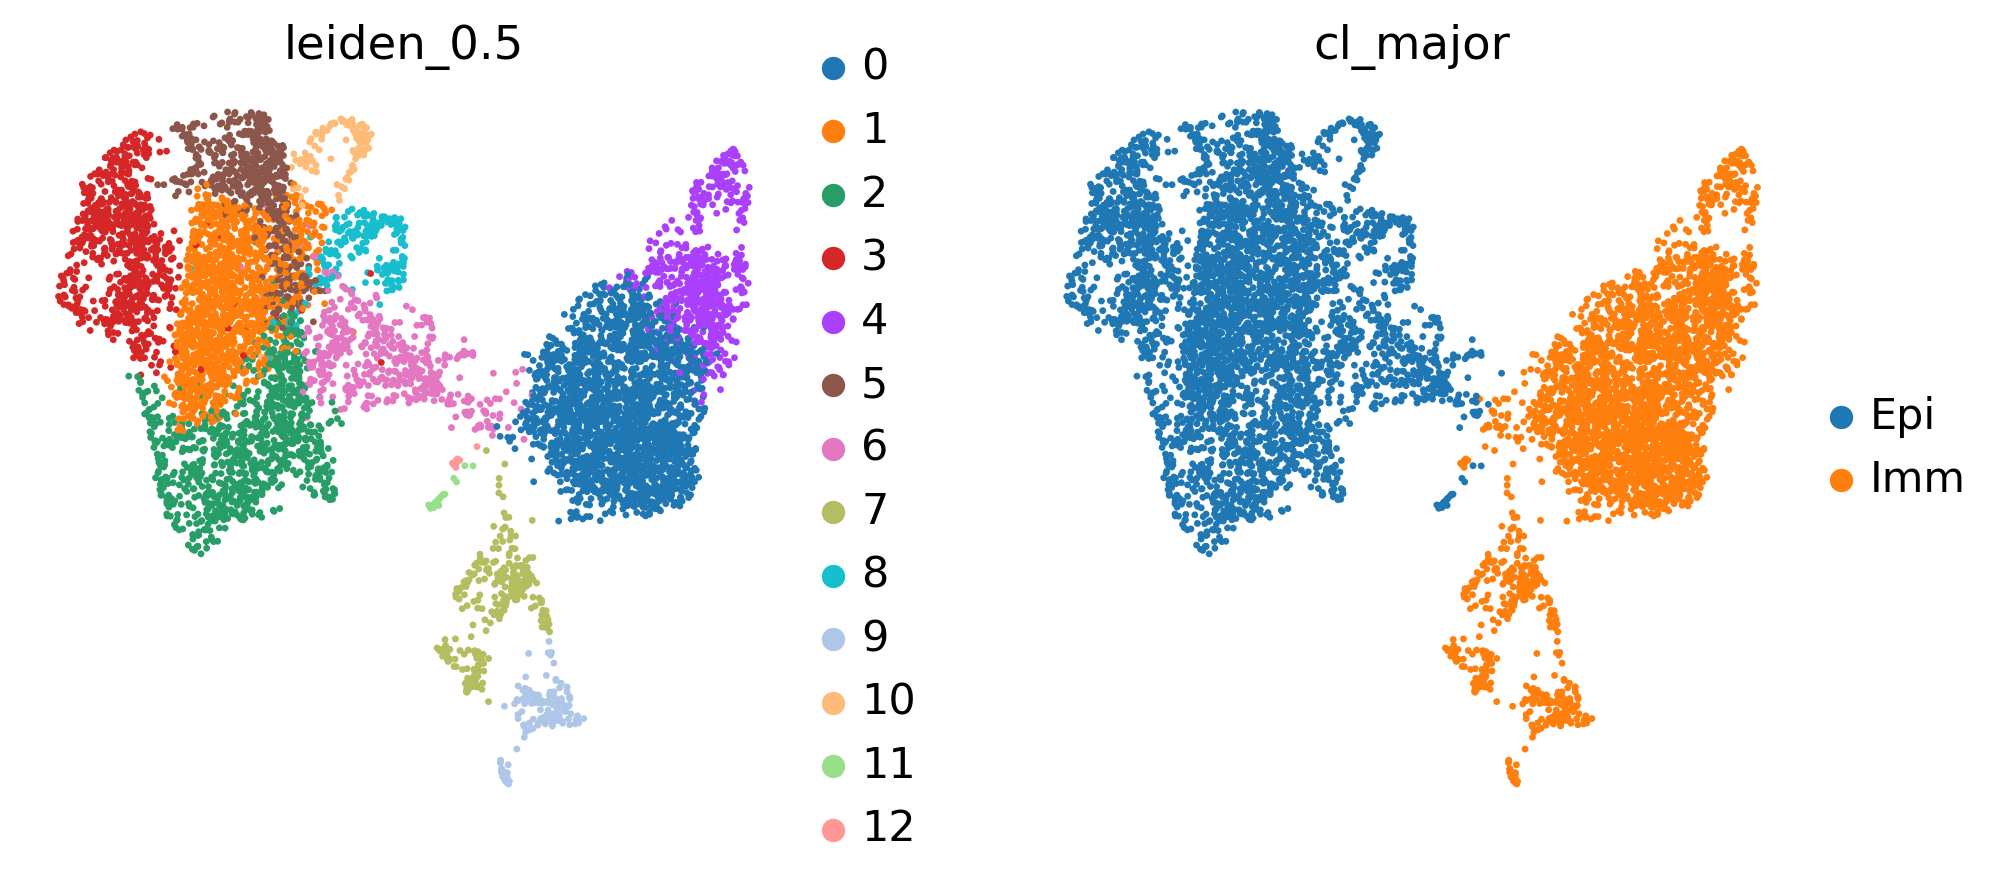

In [145]:
sc.pl.umap(adata, color=[ "leiden_0.5","cl_major"], frameon=False, ncols=4)

In [146]:
adata.obs.to_csv(resdir+'/'+location+'/'+filtertype+'_celltype.csv')

In [166]:
import scanpy.external as sce

In [167]:
sce.pp.harmony_integrate(adata, ['SampleID'],max_iter_harmony=20)

2024-01-13 20:59:54,196 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-01-13 21:00:31,331 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-01-13 21:00:31,646 - harmonypy - INFO - Iteration 1 of 20
2024-01-13 21:00:40,528 - harmonypy - INFO - Iteration 2 of 20
2024-01-13 21:00:50,955 - harmonypy - INFO - Iteration 3 of 20
2024-01-13 21:01:01,802 - harmonypy - INFO - Iteration 4 of 20
2024-01-13 21:01:13,103 - harmonypy - INFO - Iteration 5 of 20
2024-01-13 21:01:25,423 - harmonypy - INFO - Converged after 5 iterations


In [168]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony',n_neighbors=15, n_pcs=40)
sc.tl.umap(adata,min_dist=0.5)

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


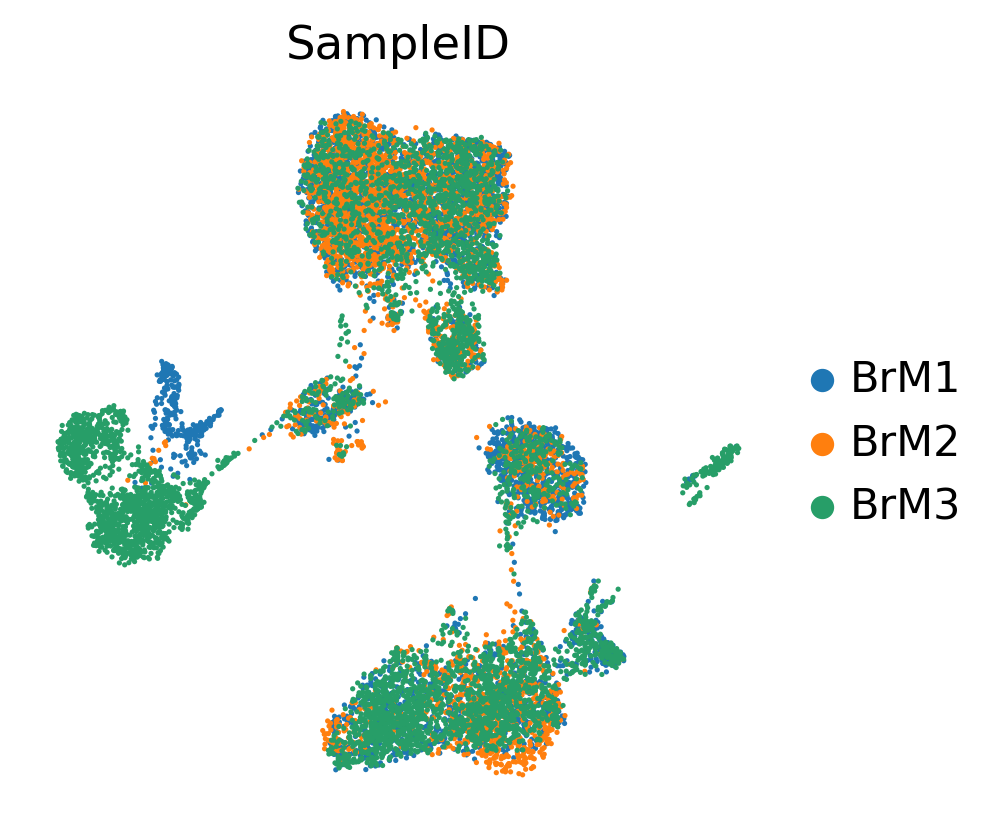

In [169]:
sc.pl.umap(adata, color=["SampleID"], frameon=False, ncols=2)

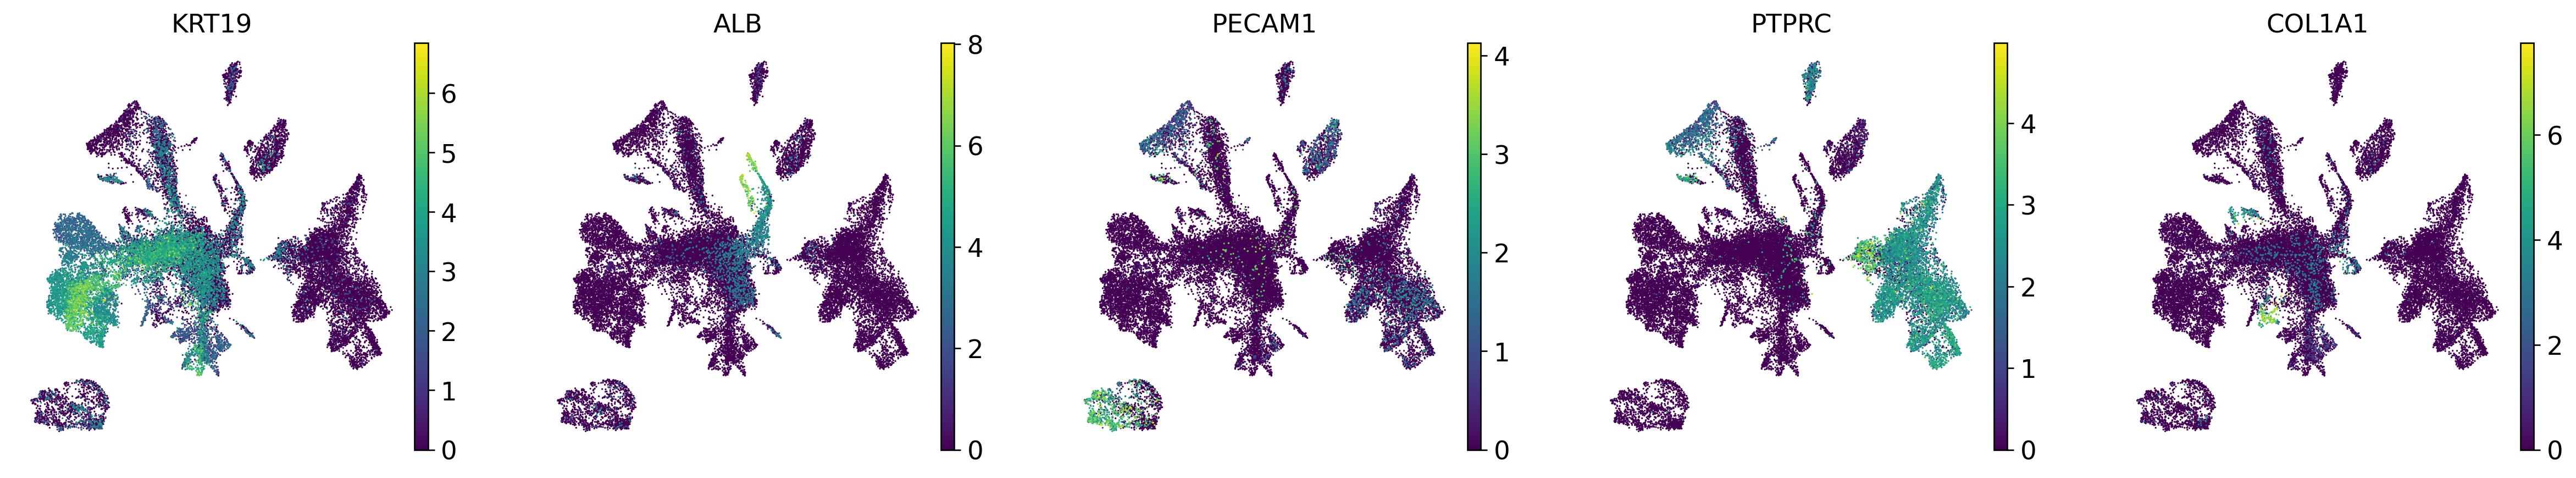

In [45]:
sc.pl.umap(adata,color = ['KRT19','ALB','PECAM1','PTPRC','COL1A1'],frameon= False, ncols = 5, use_raw = True)

In [171]:
for i in [0.5,1.0,1.5]:
    sc.tl.leiden(adata, resolution = i, key_added = ('harmony_leiden_'+str(i)))

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.ma

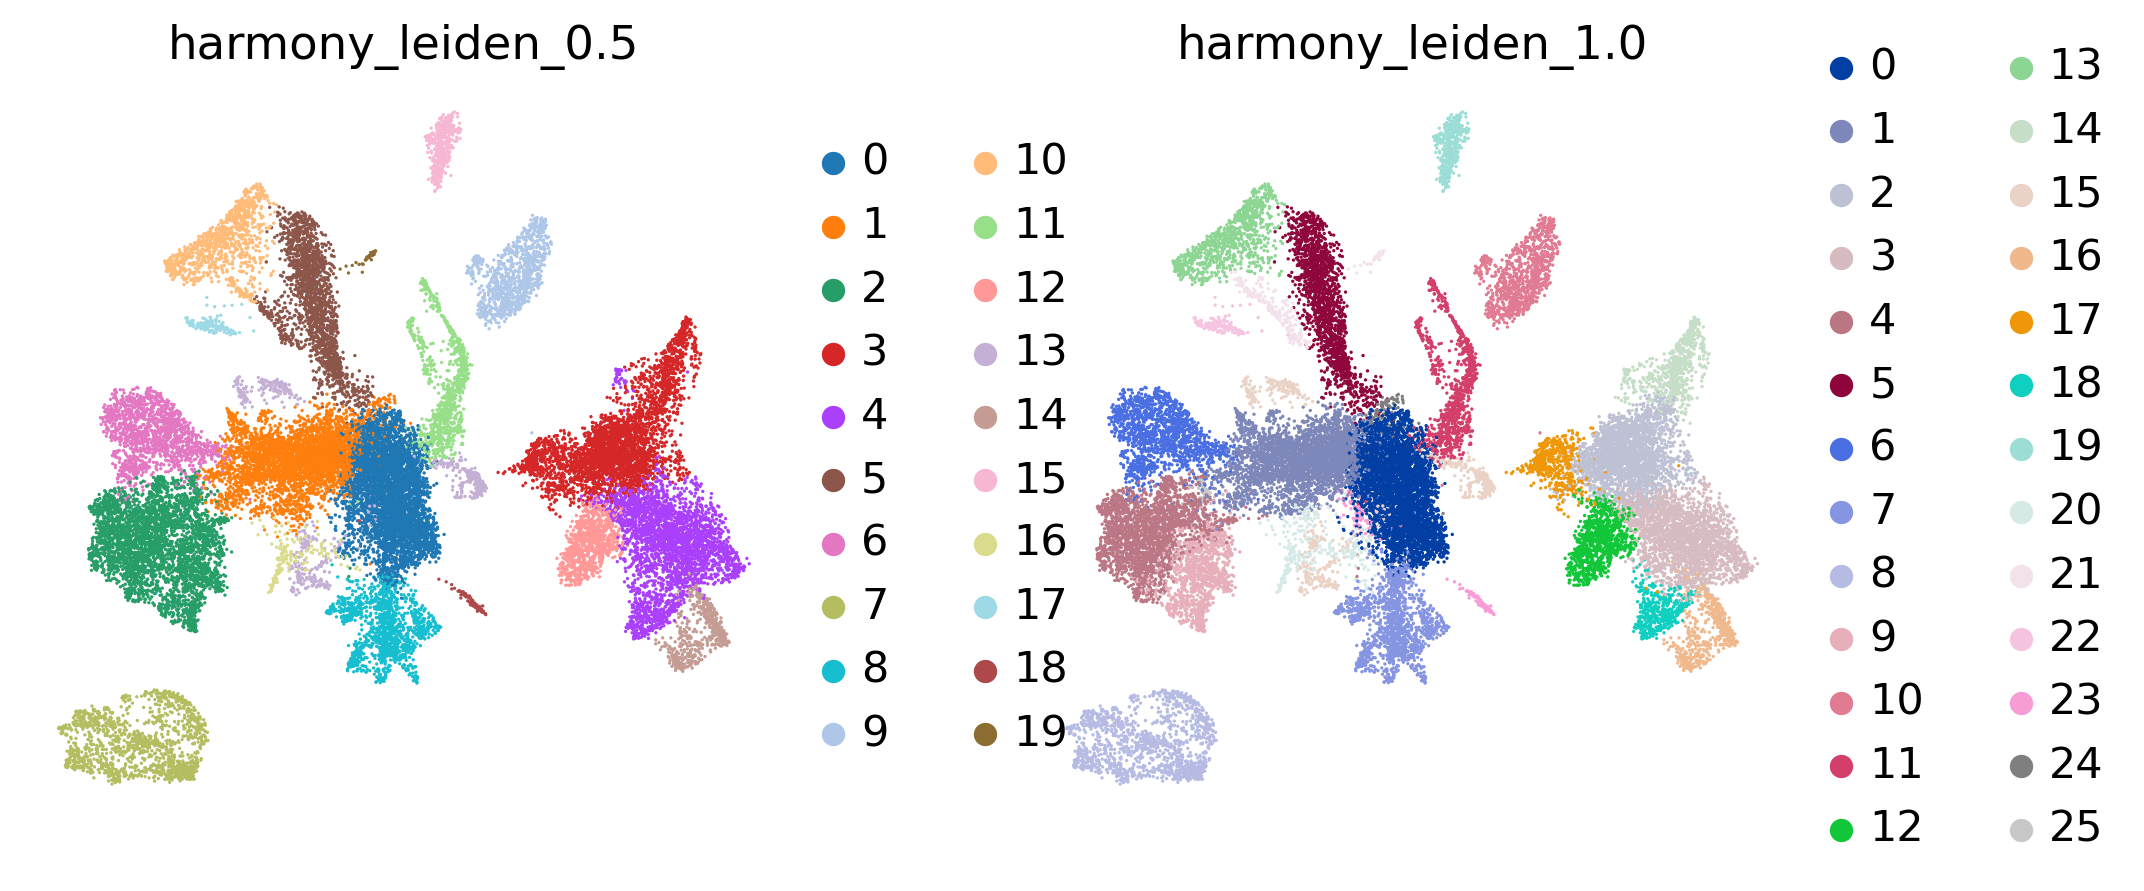

In [9]:
sc.pl.umap(adata, color=[ "harmony_leiden_0.5","harmony_leiden_1.0"], frameon=False, ncols=4)

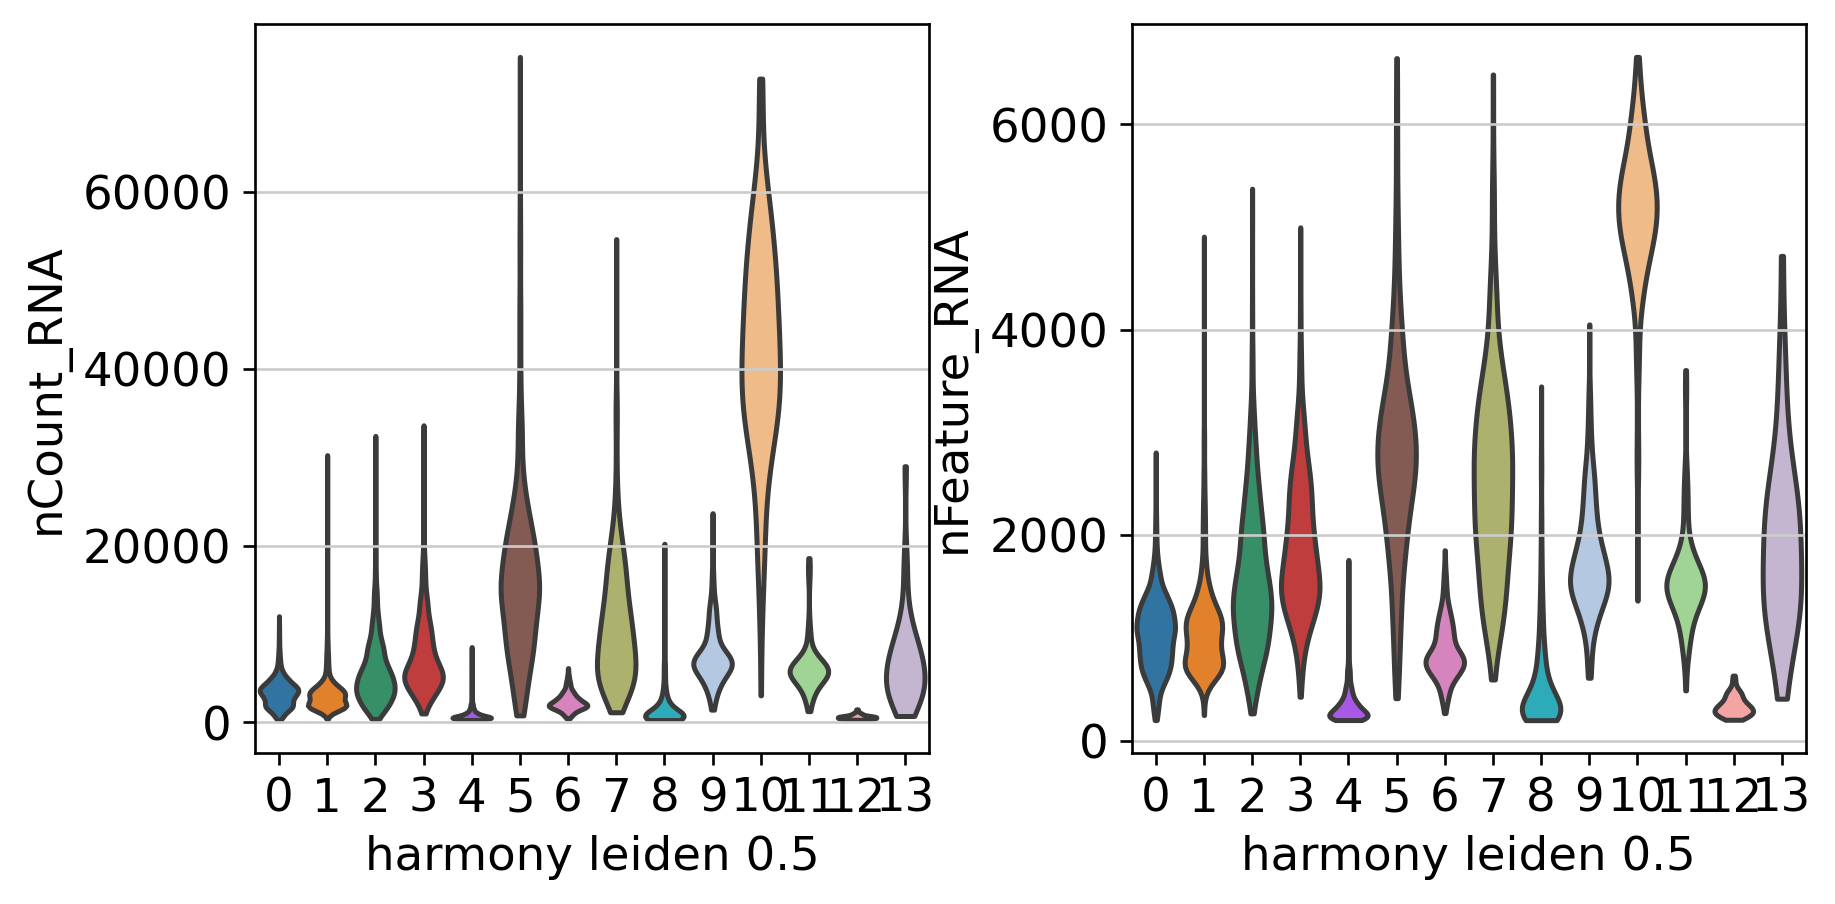

In [173]:
%%capture --no-display
sc.pl.violin(adata, ['nCount_RNA','nFeature_RNA'],groupby='harmony_leiden_0.5',
             jitter=0.4, multi_panel=True,stripplot=False,fontszie=1)

In [ ]:
adata.write_h5ad(resdir+'/'+location+'/'+location+'_'+filtertype+'_harmony.h5ad')

In [ ]:
adata = sc.read_h5ad(resdir+'/'+location+'/'+location+'_'+filtertype+'_harmony.h5ad')

In [ ]:
pd.crosstab(adata.obs['harmony_leiden_0.5'],adata.obs['SampleID'])

In [ ]:
# 24-cycling keep
# 31, 33 remove

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


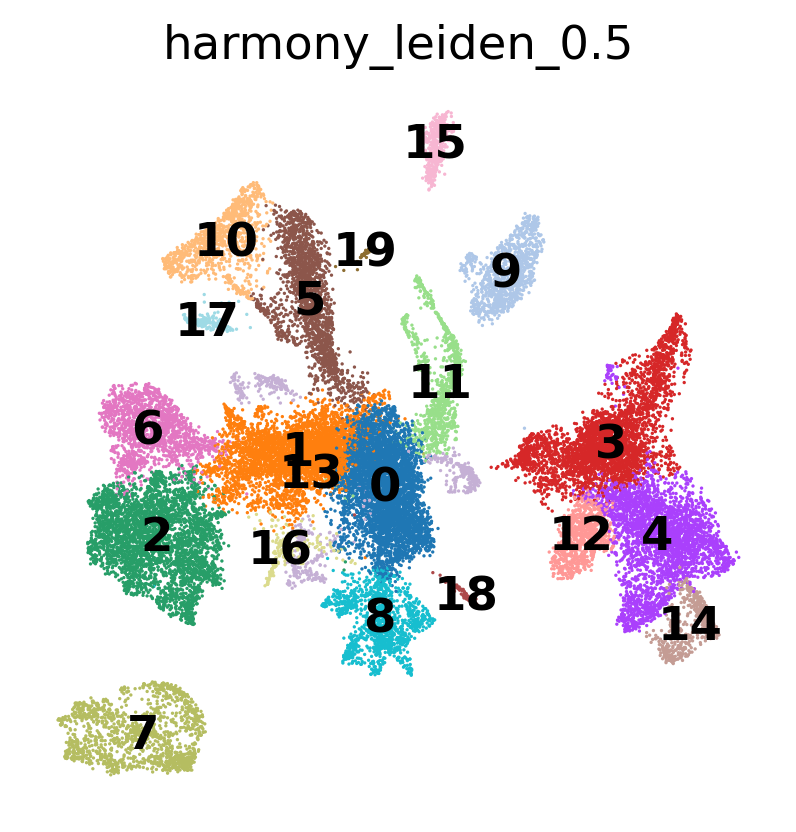

In [13]:
cluster_select = 'harmony_leiden_0.5'
sc.pl.umap(adata, color=[cluster_select], legend_loc= 'on data',frameon=False)

In [12]:
adata_qc = sc.read_h5ad(resdir+'/'+location+'/'+location+'_'+filtertype+'_qc.h5ad')

In [14]:
adata_qc.obs = adata_qc.obs.join(adata.obs[cluster_select], how='left')

In [15]:
sc.pp.normalize_total(adata_qc, target_sum = 1e4)
sc.pp.log1p(adata_qc)

In [16]:
%%capture --no-display
sc.tl.rank_genes_groups(adata_qc, cluster_select, method='wilcoxon')

In [17]:
marker_enrich = pd.DataFrame(adata_qc.uns['rank_genes_groups']['names'])

In [18]:
import gseapy as gp

In [43]:
interest_cluster = '18'
marker_enrich[interest_cluster].head(10)

0       PKHD1
1      ZBTB20
2    SERPINA1
3      TM4SF4
4       BICC1
5      SORBS2
6       DCDC2
7      CYP3A5
8       CLDN1
9       ANXA4
Name: 18, dtype: object

In [44]:
enr = gp.enrichr(marker_enrich[interest_cluster].head(30), gene_sets=['Azimuth_2023'], organism='human', outdir=None)
enr.results.head(5)

Gene_set                                        Term Overlap  \
0  Azimuth_2023                          Pancreas-L1-ductal     5/9   
1  Azimuth_2023           Fetal Development-L1-Ductal Cells     3/9   
2  Azimuth_2023  Fetal Development-L2-Pancreas-Ductal Cells     3/9   
3  Azimuth_2023                      Liver-L1-Cholangiocyte     3/9   
4  Azimuth_2023                      Liver-L2-Cholangiocyte     3/9   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  6.706228e-13      5.432045e-11            0                     0   
1  2.542401e-07      4.118689e-06            0                     0   
2  2.542401e-07      4.118689e-06            0                     0   
3  2.542401e-07      4.118689e-06            0                     0   
4  2.542401e-07      4.118689e-06            0                     0   

   Odds Ratio  Combined Score                              Genes  
0  998.300000    27982.917541  MMP7;SERPINA1;ANXA4;SERPING1;CFTR  
1  369.703704     5613.945898                     FXYD2;CLU;CFTR  
2  369.703704     5613.945898                     FXYD2;CLU;CFTR  
3  369.703704     5613.945898                 FXYD2;DEFB1;TM4SF4  
4  369.703704     5613.945898                 FXYD2;DEFB1;TM4SF4

In [206]:
cl_major={
    "0": "Imm",
    "1": "Imm",
    "2": "Imm",
    "3": "Imm",
    "4": "Imm",
    "5": "Epi",
    "6": "Imm",
    "7": "Epi",
    "8": "Epi",
    "9": "Imm",
    "10": "Epi",
    "11": "Imm",
    "12": "Imm",
    "13": "Imm",
    
}

In [207]:
adata.obs["cl_major"] = adata.obs[cluster_select].map(cl_major)

/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/zhepan/miniconda3/envs/scRNA/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.ma

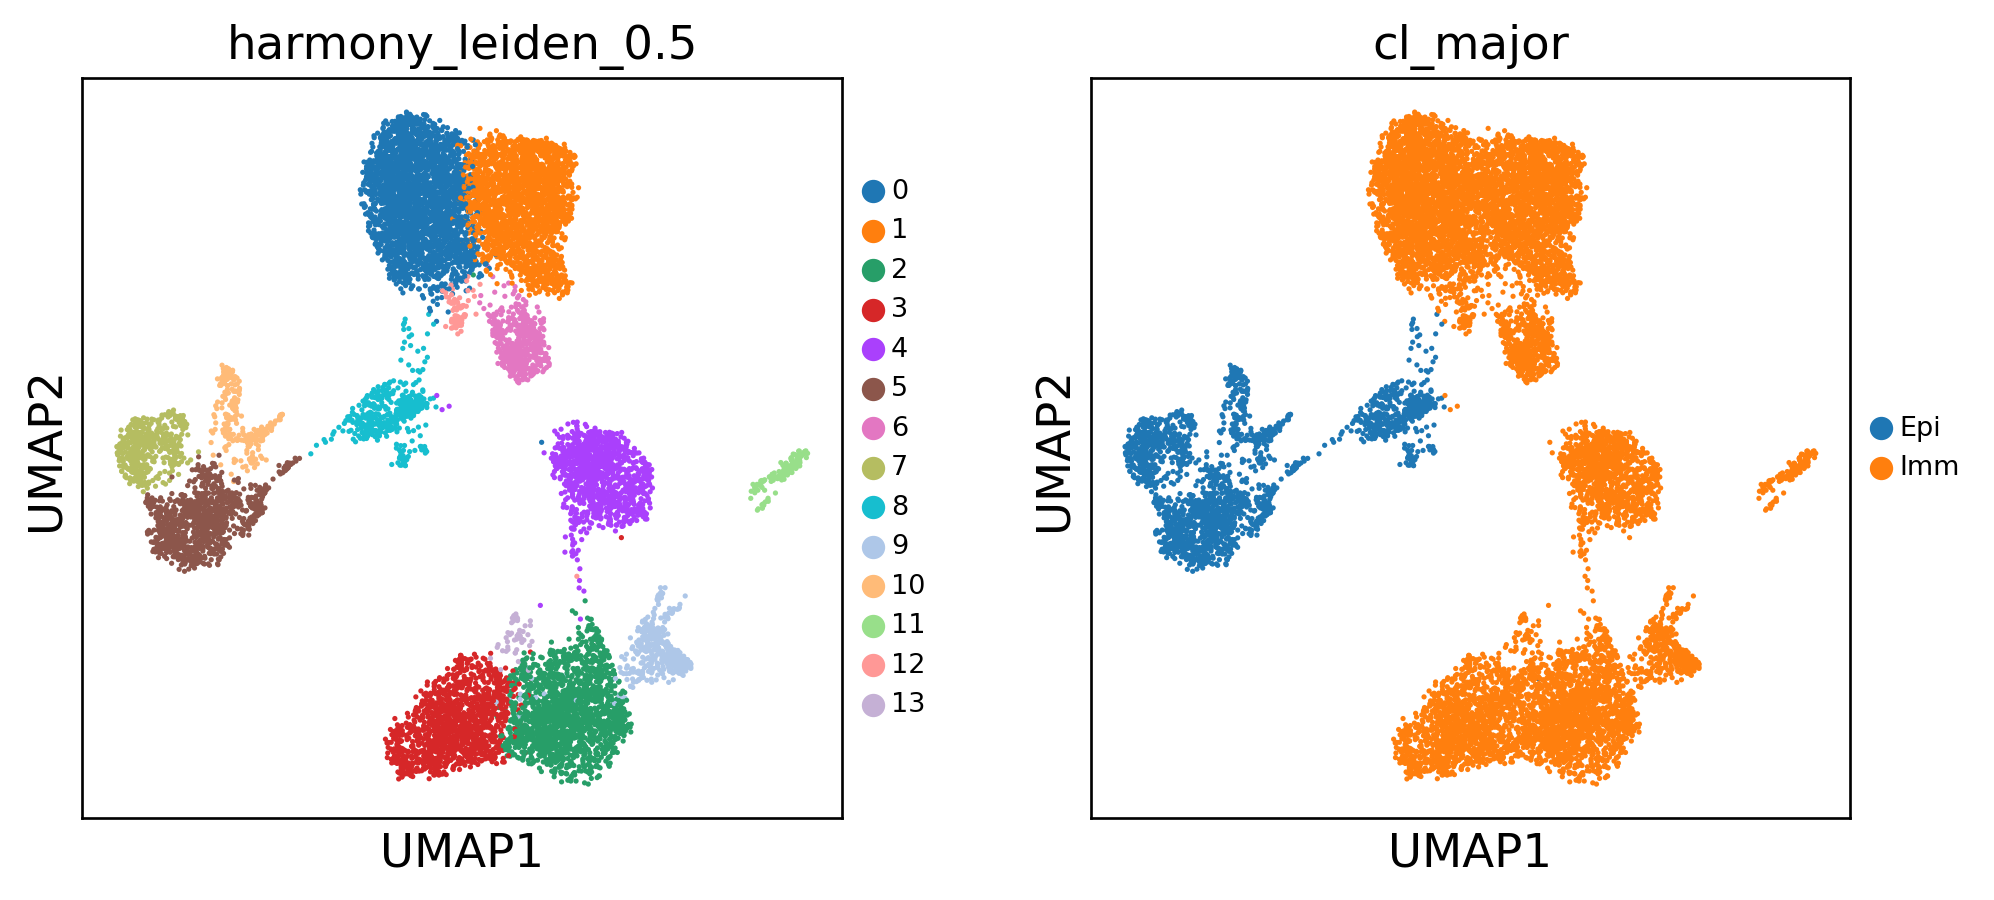

In [210]:
sc.pl.umap(adata, color = [cluster_select,'cl_major'], ncols=2, legend_fontsize='xx-small')

In [211]:
adata.obs.to_csv(resdir+'/'+location+'/'+location+'_'+filtertype+'_celltype.csv')

In [298]:
adata.write_h5ad(resdir+'/'+location+'/'+location+'_'+filtertype+'_anno.h5ad')

In [ ]:
adata_keep = sc.read_h5ad(resdir+'/'+location+'/'+location+'_'+filtertype+'_anno.h5ad')

In [ ]:
sc.pl.umap(adata_keep,color = ['cl_major'], frameon=False)

In [ ]:
tmp = pd.crosstab(adata_keep.obs['SampleID'],adata_keep.obs['cl_minor'], normalize='columns').T.plot(kind='bar', stacked=True,figsize = (4,4))
plt.grid(False)
tmp.legend(title='celltype', bbox_to_anchor=(1.26, 1.02),loc='best',frameon = False,fontsize='xx-small')

In [ ]:
tmp = pd.crosstab(adata_keep.obs['cl_minor'],adata_keep.obs['SampleID'], normalize='columns').T.plot(kind='bar', stacked=True,figsize = (4,4))
plt.grid(False)
tmp.legend(title='celltype', bbox_to_anchor=(1.5, 1.02),loc='best',frameon = False, fontsize='xx-small')

In [ ]:
adata_keep = sc.read_h5ad(resdir+'/'+location+'/'+location+'_'+filtertype+'_anno.h5ad')
anno = pd.read_table(resdir+'/'+location+'/'+location+'_'+filtertype+'_celltype.txt',sep = '\t',index_col=0)

In [ ]:
adata_keep.obs = anno

In [ ]:
adata_keep = adata_keep[adata_keep.obs['cl_subset'].isin(['Keratinocyte','Fibroblast'])==False]

In [ ]:
select_cl = 'Keratinocyte'

In [ ]:
adata_qc = sc.read_h5ad(resdir+'/'+location+'/'+location+'_'+filtertype+'_qc.h5ad')
adata_qc.obs = adata_qc.obs.join(adata_keep.obs['cl_major'], how='left')

In [ ]:
adata_subcluster = adata_qc[adata_qc.obs['cl_major'] == select_cl,:]
adata_subcluster

In [ ]:
adata_subcluster.layers['count'] = adata_subcluster.X.copy()
sc.pp.normalize_total(adata_subcluster, target_sum=1e4)
sc.pp.log1p(adata_subcluster)
adata_subcluster.raw = adata_subcluster
sc.pp.highly_variable_genes(
    adata_subcluster,layer = 'count',
    flavor="seurat_v3",
    n_top_genes=2000,
    subset=True,
)

In [ ]:
sc.pp.scale(adata_subcluster)
sc.tl.pca(adata_subcluster, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_subcluster, log=True)

In [ ]:
sce.pp.harmony_integrate(adata_subcluster, ['SampleID'],max_iter_harmony=20)
sc.pp.neighbors(adata_subcluster, use_rep='X_pca_harmony',n_neighbors=15, n_pcs=30)

In [ ]:
sc.tl.umap(adata_subcluster,min_dist=0.5)

In [ ]:
for i in [0.2,0.4,0.6]:
    sc.tl.leiden(adata_subcluster, resolution = i, key_added = ('leiden_'+str(i)))

In [ ]:
sc.pl.umap(adata_subcluster, color=['leiden_0.2','leiden_0.4','leiden_0.6'], frameon=False)

In [ ]:
import celltypist

In [ ]:
adata_subcluster_raw = adata_qc[adata_qc.obs['cl_major'] == select_cl,:]
sc.pp.normalize_total(adata_subcluster_raw, target_sum=1e4)
sc.pp.log1p(adata_subcluster_raw)
pred_GTEx_minor = celltypist.annotate(adata_subcluster_raw, model = '/home/zhepan/Reference/celltypist/skin_minor_from_GTEx.pkl', majority_voting = True)
pred_deve_subset = celltypist.annotate(adata_subcluster_raw, model = '/home/zhepan/Reference/celltypist/skin_subset_from_Develop.pkl', majority_voting = True)

In [ ]:
adata_subcluster.obs = adata_subcluster.obs.join(pred_GTEx_minor.predicted_labels['majority_voting']).rename(columns={'majority_voting':'GTEx_minor'})
adata_subcluster.obs = adata_subcluster.obs.join(pred_deve_subset.predicted_labels['majority_voting']).rename(columns={'majority_voting':'deve_subset'})

In [ ]:
sc.pl.umap(adata_subcluster, color=['GTEx_minor','deve_subset'], ncols=1)

In [ ]:
select_res = 'leiden_0.2'

In [ ]:
adata_subcluster_raw.obs = adata_subcluster_raw.obs.join(adata_subcluster.obs[select_res])

In [ ]:
sc.tl.rank_genes_groups(adata_subcluster_raw, select_res, method='wilcoxon')

In [ ]:
adata = sc.read_h5ad(resdir+'/'+location+'/'+location+'_'+filtertype+'_anno_count.h5ad')

In [ ]:
adata.layers['count'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [ ]:
marker_enrich = pd.DataFrame(adata_subcluster_raw.uns['rank_genes_groups']['names'])

In [ ]:
interest_cluster = '6'
marker_enrich[interest_cluster].head(10)

In [ ]:
enr = gp.enrichr(marker_enrich[interest_cluster].head(30), gene_sets=['Azimuth_2023'], organism='human', outdir=None)
enr.results.head(5)

In [ ]:
sc.pl.umap(adata_subcluster, color=[select_res], ncols=1,legend_loc='on data')

In [ ]:
cl_major={
    "0": "Fibroblast",
    "1": "Fibroblast",
    "2": "Fibroblast",
    "3": "Fibroblast",
    "4": "Fibroblast",
    "5": "Fibroblast",
    "6": "Fibroblast",
    "7": "Fibroblast",
    "8": "Fibroblast",
    "9": "Fibroblast",
    "10": "Fibroblast",
}

In [ ]:
adata_subcluster.obs["cl_major"] = adata_subcluster.obs[select_res].map(cl_major)

In [ ]:
cl_minor={
    "0": "Fib-ANXA1",
    "1": "Fib-IGFBP7",
    "2": "Fib-COL23A1",
    "3": "Fib-ASAP1",
    "4": "Fib-ITPR2",
    "5": "Fib-BNC2",
    "6": "Fib-TCF4",
}

In [ ]:
adata_subcluster.obs["cl_minor"] = adata_subcluster.obs[select_res].map(cl_minor)

In [ ]:
sc.pl.umap(adata_subcluster,color = ['cl_major','cl_minor'], frameon=False)

In [ ]:
adata_subcluster.obs.to_csv(resdir+'/'+location+'/'+location+'_'+filtertype+'_'+select_cl+'_'+'sub_celltype.csv')

In [ ]:
sc.pl.umap(adata_keep,color = ['cl_minor'], frameon=False,ncols=1,legend_fontsize='xx-small',save='_major.png')

In [ ]:
sc.pl.umap(adata_keep,color = 
    ['KRT10','KRT15','IL18',
    'PTPRC','CD2','CD207',
    'VWF','COL1A1',],
    frameon=False, ncols=8, colorbar_loc=None, save='_marker.png')

In [ ]:
adata_qc = sc.read_h5ad(resdir+'/'+location+'/'+location+'_'+filtertype+'_qc.h5ad')

In [ ]:
adata_anno_count = adata_qc[adata_qc.obs.index.isin(adata_keep.obs.index),:]

In [ ]:
adata_anno_count.write_h5ad(resdir+'/'+location+'/'+location+'_'+filtertype+'_anno_count.h5ad')

In [ ]:
adata = sc.read_h5ad(resdir+'/'+location+'/'+location+'_'+filtertype+'_anno.h5ad')

In [ ]:
sc.pl.umap(adata,color = ['SampleType'], frameon=False, ncols=1, legend_fontsize='xx-small', show=False, save='_sampleType.png')

In [ ]:
sc.pl.umap(adata,color = ['SampleID'], frameon=False, ncols=1, legend_fontsize='xx-small', show=False, save='_sampleID.png')

In [ ]:
sc.pl.umap(adata,color = ['cl_major'], frameon=False, ncols=1, legend_fontsize='xx-small', show=False, save='_major.png')
#sc.pl.umap(adata,color = ['cl_minor'], frameon=False, ncols=1, legend_fontsize='xx-small', show=False, save='_minor.png')
#sc.pl.umap(adata,color = ['cl_subset'], frameon=False, ncols=1, legend_fontsize='xx-small', show=False, save='_subset.png')

In [ ]:
sc.pl.umap(adata,color = 
    ['KRT10','KRT15','IL18',
    'PTPRC','CD2','CD207',
    'VWF','COL1A1',],
    frameon=False, ncols=8, colorbar_loc=None, show = False, save='_marker.png')

In [ ]:
adata = sc.read_h5ad(resdir+'/'+location+'/'+location+'_'+filtertype+'_anno_count.h5ad')

In [ ]:
subset_cl = 'Keratinocyte'

In [ ]:
adata_subcluster = adata[adata.obs['cl_major'] == subset_cl,:]

In [ ]:
adata_subcluster.write_h5ad(resdir+'/'+location+'/'+location+'_'+filtertype+'_'+subset_cl+'_count.h5ad')

In [ ]:
adata_subcluster

In [ ]:
adata_subcluster = sc.read_h5ad('/home/zhepan/Project/MultiOmics/data/snRNA/Object/summary/Myeloid/myeloid_count.h5ad')

In [ ]:
adata_subcluster.layers['count'] = adata_subcluster.X.copy()
sc.pp.normalize_total(adata_subcluster, target_sum=1e4)
sc.pp.log1p(adata_subcluster)
adata_subcluster.raw = adata_subcluster

In [ ]:
sc.pp.highly_variable_genes(
    adata_subcluster,layer = 'count',
    flavor="seurat_v3",
    n_top_genes=3000,
    subset=True,
    batch_key = 'SampleID', span = 0.5
)
sc.pp.scale(adata_subcluster)
sc.tl.pca(adata_subcluster, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_subcluster, log=True)

In [ ]:
import scanpy.external as sce

In [ ]:
sce.pp.harmony_integrate(adata_subcluster, ['SampleID'],max_iter_harmony=20)
sc.pp.neighbors(adata_subcluster, use_rep='X_pca_harmony',n_neighbors=40, n_pcs=30)
sc.tl.umap(adata_subcluster,min_dist=0.5)

In [ ]:
sc.pl.umap(adata_subcluster,color = ['cl_subset'], frameon=False, ncols=1, legend_fontsize='xx-small', show=True,save='_'+subset_cl+'_subset.png')

In [ ]:
adata_subcluster.write_h5ad(resdir+'/'+filtertype+'_'+subset_cl+'_subset.h5ad')

In [ ]:
adata_subcluster = sc.read_h5ad(resdir+'/'+filtertype+'_'+subset_cl+'_subset.h5ad')

In [ ]:
sc.pl.umap(adata_subcluster,color = ['cl_subset'], frameon=False, ncols=1, legend_fontsize='xx-small', show=True)

In [ ]:
adata_subcluster.uns

In [ ]:
sc.pl.umap(adata_subcluster,color = ['HALLMARK_INFLAMMATORY_RESPONSE'], frameon=False, ncols=1, legend_fontsize='xx-small', show=True)

In [ ]:
adata = sc.read_h5ad(resdir+'/'+filtertype+'_anno_count.h5ad')
adata.layers['count'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

In [ ]:
sc.tl.rank_genes_groups(adata, 'cl_minor', method='wilcoxon')

In [ ]:
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.25)

In [ ]:
marker_enrich = pd.DataFrame(adata.uns['rank_genes_groups_filtered']['names'])

In [ ]:
marker_enrich.head(20)

In [ ]:
adata.obs.cl_minor.value_counts()

In [ ]:
marker_genes_dict = {
    "KC-Basal" : ["KRT14", "KRT5", "COL17A1"],
    "KC-Suprabasal" : ["KRT10","KRT1"],
    "KC-Spinous" : ["SPINK5"],
    "KC-Proliferating" : ["DIAPH3", "CENPP", "ASPM"],
    "KC-Cycling" : ["KIAA1217"],
    "T" : ["PTPRC", "IL7R","CD2"],
    "NK" : ["CD96"],
    "Macrophage" : ["ZEB2","SLC8A1"],
    "DC" : ["CD74", "ETV6", "CSF2RA"],
    "LC" : ["PRKCB"],
    "Mast cell" : ["TNIK", "NTM"],
    "Melanocyte" : ["TRPM1", "FMN1"], # Melanocyte markers
    "Endo-Vas" : ["VWF", "PECAM1", "MCTP1"], 
    "Endo-Lymph" : ["PKHD1L1", "KALRN"], 
    "PVL" : ["ACTA2"],
    "Fibroblasts" : ["COL1A1", "COL3A1"], 
    "Schwann" : ["NRXN1", "CADM2"],
}


In [ ]:
sc.pl.dotplot (adata, marker_genes_dict, standard_scale='var', groupby='cl_minor', dendrogram=False, use_raw=True, cmap='viridis')

In [ ]:
adata_subcluster = sc.read_h5ad(resdir+'/'+filtertype+'_keratinocyte_subset.h5ad')

In [ ]:
enrich_res = pd.read_table(resdir+'/'+'ssgsea_kera.txt',sep = '\t',index_col=0)
adata_subcluster.obs = adata_subcluster.obs.join(enrich_res)

In [ ]:
adata_subcluster.obs.columns.tolist()

In [ ]:
sc.pl.umap(adata_subcluster,color = [ "KRT15",'DSC3','SOX6','KRT10','STK10','DIAPH3','S100A2'],frameon= False, ncols = 8,  colorbar_loc=None,use_raw = True,save='_kera_marker.png')

In [ ]:
select_score = 'HALLMARK_TGF_BETA_SIGNALING'

In [ ]:
sc.pl.umap(adata_subcluster[adata_subcluster.obs['SampleType'] == 'H',:],color = [select_score], frameon=False, ncols=1, legend_fontsize='xx-small', colorbar_loc=None)
sc.pl.umap(adata_subcluster[adata_subcluster.obs['SampleType'] == 'N',:],color = [select_score], frameon=False, ncols=1, legend_fontsize='xx-small', colorbar_loc=None)

In [ ]:
adata = sc.read_h5ad('/home/zhepan/Project/MultiOmics/data/snRNA/Object/summary/Myeloid/myeloid_.h5ad')
anno = pd.read_table('/home/zhepan/Project/MultiOmics/data/snRNA/Object/summary/annotation/myeloid_cluster.tsv',sep = '\t',index_col=0)

In [ ]:
adata.obs = anno

In [ ]:
adata

In [ ]:
sc.pl.umap(adata, color = ['SampleID','SampleTimepoint'], ncols = 1)

In [ ]:
sc.pl.umap(adata, color = ['myeloid_minor_order'], ncols = 1)

In [ ]:
adata.obs.to_csv(resdir+'/myeloid_celltype.csv')

In [ ]:
sc.pl.umap(adata, color = ['TREM2','FOLR2','SPP1'])